In [98]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
import time
from pbdlib import plot_gmm
from scipy.special import digamma
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
from scipy.stats import t
from scipy.special import loggamma
from sklearn.metrics import mean_squared_error as mse
from IPython.display import clear_output

In [69]:
from math import *

def t_logpdf(x,df,mu,Sigma):
    '''
    Multivariate t-student density:
    output:
        the density of the given element
    input:
        x = parameter (d dimensional numpy array or scalar)
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
        d: dimension
    '''
    d = x.shape[0]
    Num = loggamma(1. * (d+df)/2)
    Denom =  loggamma(1.*df/2) + 0.5*d*np.log(df*pi)   + 0.5*np.log(np.linalg.det(Sigma)) + \
            (0.5*(d+df))*np.log(1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu)))
    d = Num - Denom  
    return d

In [109]:
def calc_MSLL(y_pred, y_cov, y_true, train_mean, train_var):
    n = y_pred.shape[0]
    MSLL = 0
    for i in range(n):
        SLL_trivial = 0.5*np.log(2*np.pi*train_var) + ((train_mean-y_true[i])**2)/(2*train_var)
        MSLL += 0.5*np.log(2*np.pi*y_cov[i]) + ((y_pred[i]-y_true[i])**2)/(2*y_cov[0]) - SLL_trivial
    MSLL /= n
    return MSLL

In [70]:
def log_normalize(x):
    return x - logsumexp(x)

In [71]:
def filter_gaussian(means_, covariances_, weights_, threshold = 0.01):
    means = [] 
    covs = []
    for i,w in enumerate(weights_):
        if w > threshold:
            means.append(means_[i])
            covs.append(covariances_[i])
    
    means = np.array(means)
    covs = np.array(covs)
    return means,covs

### Define class for GMM and GMR

In [72]:
from sklearn.cluster import KMeans
class GMM():
    def __init__(self, n_comp = 10, D = 1, K = 2, weight_concentration = 0.1):
        self.n_comp = n_comp
        self.D = D
        self.K = K

        #pi params
        self.alpha0 = np.ones(K)*weight_concentration
        self.alpha = np.copy(self.alpha0)

        #mu and sigma params
        self.betha0 = 0.0001
        self.betha = np.ones(self.K)
        self.mu0 = np.zeros(self.D)
        self.v0 = self.D
        self.W0 = np.eye(self.D)/(self.v0)
        #
        self.W = [np.eye(self.D) for i in range(self.K)]
        self.v = np.ones(self.K)*self.D
        
        self.reg_covar = 1e-06
        
    def fit(self,x, num_iter = 10,restart=True):
        self.x = x
        cov = np.cov(x.T)
        #self.W0 = np.linalg.inv(cov)/self.v0
        self.N = self.x.shape[0]
        if restart:
            kMM = KMeans(n_clusters=self.K).fit(x)
            self.mu = kMM.cluster_centers_
            #self.mu = x[np.random.choice(len(x),size = self.K)]
        for i in range(num_iter):
            print 'Iteration ' + str(i)
            self.expectation()
            self.maximization()
            
        self.sigma = []
        for k in range(self.K):
            sigma = np.linalg.inv(self.v[k]*self.W[k])
            self.sigma.append(sigma)

        self.weights = self.alpha/np.sum(self.alpha)


    def expectation(self):
        self.ln_ro = np.zeros([self.N,self.K])
        self.ro = np.zeros([self.N,self.K])

        print 'Calculating ro'
        tic = time.time()
        for k in range(self.K):
            E_s = self.D*np.log(2) + np.log(np.linalg.det(self.W[k])) + np.sum([digamma((self.v[k] + 1 - i)/2.) \
                                                                           for i in range(self.D)])
            E_pi = digamma(self.alpha[k]) - digamma(np.sum(self.alpha))
            E_2 = self.D*np.log(2*np.pi)
            for n in range(self.N):
                E_ms = self.D/self.betha[k] + self.v[k]*np.dot(self.x[n] - self.mu[k], np.dot(self.W[k], \
                                                                                self.x[n] - self.mu[k]))
                self.ln_ro[n,k] = E_pi + 0.5*E_s - 0.5*E_2 - 0.5*E_ms

        for n in range(self.N):        
            self.ln_ro[n,:] = log_normalize(self.ln_ro[n,:])
            self.ro[n,:] = np.exp(self.ln_ro[n,:])
        toc = time.time()
        print toc-tic


        self.Nks = np.array([1e-12 + np.sum(self.ro[:,k]) for k in range(self.K)])

        self.xks = np.dot(self.ro.T, self.x)
        for k in range(self.K):
            self.xks[k,:] /= self.Nks[k]


        print 'Calculating Sk' 
        self.Sks = []
        for k in range(self.K):
            Sk = np.zeros([self.D,self.D])
            for n in range(self.N):
                Sk += self.ro[n,k]*np.outer(self.x[n]-self.xks[k], self.x[n]-self.xks[k])
            Sk /= self.Nks[k]
            self.Sks.append(Sk)

        toc = time.time()
        print toc-tic

             
    def maximization(self):
        self.alpha = self.alpha0 + self.Nks
        self.betha = self.betha0 + self.Nks

        for k in range(self.K):
            self.mu[k] = (self.betha0*self.mu0 + self.Nks[k]*self.xks[k])/self.betha[k]
            Wk_inv = np.linalg.inv(self.W0 + self.reg_covar*np.eye(self.D)) + self.Nks[k]*self.Sks[k] + np.outer(self.xks[k]-self.mu0, \
                                    self.xks[k]-self.mu0)*self.betha0*self.Nks[k]/(self.betha0+self.Nks[k])
            self.W[k] = np.linalg.inv(Wk_inv+ self.reg_covar*np.eye(self.D))
            self.v[k] = self.v0 + self.Nks[k]
            
    def plot(self):
        fig,ax = plt.subplots()
        plot_gaussian(self.mu, self.sigma, ax, self.weights )


In [73]:
class BGMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []

        
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        
        self.vy_x = self.GMM.v + self.n_in
        
        
    def predict(self,x):
        h = []
        mu = []        
        sigma = []

        for k in range(self.GMM.K):
            h.append(np.log(self.GMM.weights[k])+ t_logpdf(x, self.GMM.v[k], self.mu_x[k],self.sigma_xx[k]))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xy[k].T, \
                                            np.dot(np.linalg.inv(self.sigma_xx[k]), x - self.mu_x[k])))
            sigma.append( (self.GMM.v[k] + np.dot(x-self.mu_x[k], np.dot(np.linalg.inv(self.sigma_xx[k]), x-self.mu_x[k]))) \
            *(self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k]))) \
            / self.vy_x[k])
              
        h = np.array(h)
        h = np.exp(log_normalize(h))
        #h = h/np.sum(h)
        mu = np.array(mu)
        #print h,mu
        #print h.shape,mu.shape
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

In [74]:
class GMR():
    def __init__(self, GMM, n_in, n_out):
        self.GMM = GMM
        self.n_in = n_in
        self.n_out = n_out
        #segment the gaussian components
        self.mu_x = []
        self.mu_y = []
        self.sigma_xx = []
        self.sigma_yy = []
        self.sigma_xy = []
        self.sigma_xyx = []
        for k in range(self.GMM.K):
            self.mu_x.append(self.GMM.mu[k][0:self.n_in])        
            self.mu_y.append(self.GMM.mu[k][self.n_in:])        
            self.sigma_xx.append(self.GMM.sigma[k][0:self.n_in, 0:self.n_in])        
            self.sigma_yy.append(self.GMM.sigma[k][self.n_in:, self.n_in:])        
            self.sigma_xy.append(self.GMM.sigma[k][0:self.n_in, self.n_in:])
            self.sigma_xyx.append(np.dot(self.sigma_xy[k].T,np.linalg.inv(self.sigma_xx[k])))
            
        self.mu_x = np.array(self.mu_x)
        self.mu_y = np.array(self.mu_y)
        self.sigma_xx = np.array(self.sigma_xx)
        self.sigma_yy = np.array(self.sigma_yy)
        self.sigma_xy = np.array(self.sigma_xy)
        self.sigma =[self.sigma_yy[k]- np.dot(self.sigma_xy[k].T, \
            np.dot(np.linalg.inv(self.sigma_xx[k]), self.sigma_xy[k])) for k in range(self.GMM.K)]
        
    def predict(self,x):
        h = []
        mu = []        

        for k in range(self.GMM.K):
            h.append(self.GMM.weights[k]*mvn(mean = self.mu_x[k], cov = self.sigma_xx[k]).pdf(x))
            mu.append(self.mu_y[k] + np.dot(self.sigma_xyx[k], x - self.mu_x[k]))
        
        h = np.array(h)
        h = h/np.sum(h)
        mu = np.array(mu)
        sigma = self.sigma
        
        sigma_one = np.zeros([self.n_out, self.n_out])
        mu_one = np.zeros(self.n_out)
        for k in range(self.GMM.K):
            sigma_one += h[k]*(sigma[k] + np.outer(mu[k],mu[k]))
            mu_one += h[k]*mu[k]
            
        sigma_one -= np.outer(mu_one, mu_one)
        return mu_one, sigma_one

###  Try GMM with Data

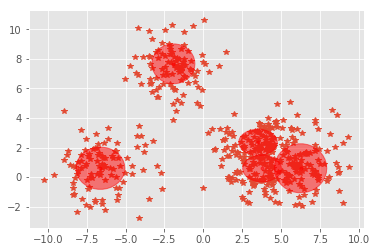

In [75]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K_true = 5
N = 500
is_plot = True

mus_true = []
sigmas_true = []
samples = []
for k in range(K_true):
    mu = 5*np.random.normal(size=D)
    sigma = 3*np.diag(np.random.rand(D))
    sample = np.random.multivariate_normal(mu, cov = sigma, size = N/K_true)
    mus_true.append(mu)
    sigmas_true.append(sigma)
    samples.append(sample)
    
x = np.vstack(samples)
mus_true = np.array(mus_true)
sigmas_true = np.array(sigmas_true)

if is_plot:
    fig,ax = plt.subplots()
    plot_gmm(mus_true,sigmas_true)#,ax)
    plt.plot(x[:,0],x[:,1],'*',zorder = 1)

In [76]:
gmm = GMM(D = 2, K = 10, weight_concentration=0.01)
gmm.fit(x,num_iter = 50)

Iteration 0
Calculating ro
0.0264670848846
Calculating Sk
0.0614681243896
Iteration 1
Calculating ro
0.0271117687225
Calculating Sk
0.0627748966217
Iteration 2
Calculating ro
0.0267820358276
Calculating Sk
0.0614869594574
Iteration 3
Calculating ro
0.0281457901001
Calculating Sk
0.06764793396
Iteration 4
Calculating ro
0.0263478755951
Calculating Sk
0.0610270500183
Iteration 5
Calculating ro
0.0262191295624
Calculating Sk
0.0609080791473
Iteration 6
Calculating ro
0.0257811546326
Calculating Sk
0.0602240562439
Iteration 7
Calculating ro
0.031790971756
Calculating Sk
0.0676591396332
Iteration 8
Calculating ro
0.0261080265045
Calculating Sk
0.0605621337891
Iteration 9
Calculating ro
0.026486158371
Calculating Sk
0.061133146286
Iteration 10
Calculating ro
0.0292789936066
Calculating Sk
0.0793960094452
Iteration 11
Calculating ro
0.0485520362854
Calculating Sk
0.112215042114
Iteration 12
Calculating ro
0.052227973938
Calculating Sk
0.113007068634
Iteration 13
Calculating ro
0.0480599403381

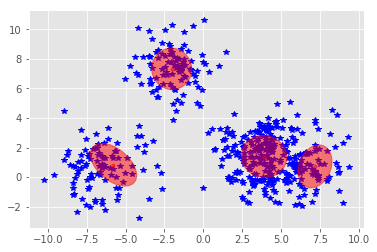

In [77]:
fig,ax = plt.subplots()
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.05)
plot_gmm(means,covs)
plt.plot(x[:,0], x[:,1], '*b',zorder=1)
plt.show()

### Try GMR on Data 

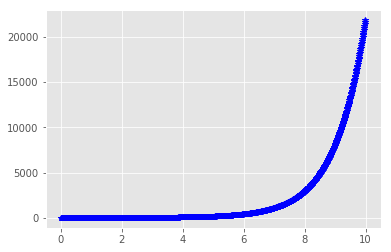

In [78]:
x_in = np.concatenate([np.arange(0,5,0.01), np.arange(5,10,0.01)])
#x_out = np.sin(2*x_in) + np.random.rand(len(x_in))*1
x_out = np.exp(x_in) + np.random.rand(len(x_in))*1

x = np.vstack([x_in, x_out]).T
plt.plot(x[:,0],x[:,1],'*b',zorder=1)

In [79]:
gmm = GMM(n_comp=10, D=2,K=30,weight_concentration=1)

In [80]:
gmm.fit(x,num_iter = 30,restart=True)

Iteration 0
Calculating ro
0.130238056183
Calculating Sk
0.351382017136
Iteration 1
Calculating ro
0.155865907669
Calculating Sk
0.380518913269
Iteration 2
Calculating ro
0.131293058395
Calculating Sk
0.354207992554
Iteration 3
Calculating ro
0.13551402092
Calculating Sk
0.358550071716
Iteration 4
Calculating ro
0.133205890656
Calculating Sk
0.353005886078
Iteration 5
Calculating ro
0.136420965195
Calculating Sk
0.361242055893
Iteration 6
Calculating ro
0.134863853455
Calculating Sk
0.353246927261
Iteration 7
Calculating ro
0.132692813873
Calculating Sk
0.350465774536
Iteration 8
Calculating ro
0.133996963501
Calculating Sk
0.354975938797
Iteration 9
Calculating ro
0.133142948151
Calculating Sk
0.355098962784
Iteration 10
Calculating ro
0.133502960205
Calculating Sk
0.356410980225
Iteration 11
Calculating ro
0.133515119553
Calculating Sk
0.352331161499
Iteration 12
Calculating ro
0.164036989212
Calculating Sk
0.413403987885
Iteration 13
Calculating ro
0.1372590065
Calculating Sk
0.3571

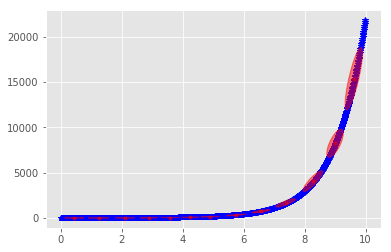

In [81]:
means, covs = filter_gaussian(gmm.mu, gmm.sigma, gmm.weights,threshold=0.01)
plot_gmm(means,covs)
plt.plot(x[:,0],x[:,1],'*b',zorder=1)
plt.show()

In [82]:
gmr = BGMR(gmm, 1, 1)

y_pred = []
y_cov = []
x_test = np.arange(-3,11,0.05)
for x_i in x_test:
    m, cov = (gmr.predict(np.array([x_i])))
    y_pred.append(m)
    y_cov.append(cov)
       
y_pred = np.array(y_pred)
y_cov = np.array(y_cov)

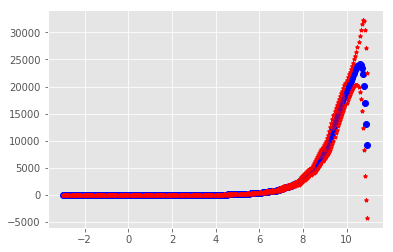

In [83]:
plt.plot(x_test, y_pred,'ob')
plt.plot(x_test, y_pred[:,0]+np.sqrt(y_cov[:,0,0]),'*r',markersize=4)
plt.plot(x_test,  y_pred[:,0]- np.sqrt(y_cov[:,0,0]),'*r',markersize=4)  
plot_gmm(means,covs)
plt.show()

### SARCOS Inverse Dynamics

In [130]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()

X_test = np.hstack([np.ones((x_test.shape[0],1)), x_test])
Y_test = y_test.copy()

#### Subsample data

In [131]:
data_train = np.hstack([X,Y])
data_test = np.hstack([X_test,Y_test])
print data_train.shape

(44484, 23)


In [132]:
indexes = np.arange(0, len(data_train),1)
np.random.shuffle(indexes)
indexes = indexes[0:2000]
data_train = data_train[indexes]

#### Learning the joint distribution of X and Y as GMM

In [133]:
gmm = GMM(K=50, D=data_train.shape[1],weight_concentration=0.01)

In [134]:
gmm.fit(data_train,num_iter=30)

Iteration 0
Calculating ro
1.04665899277
Calculating Sk
1.86941099167
Iteration 1
Calculating ro
1.06868195534
Calculating Sk
1.89353990555
Iteration 2
Calculating ro
1.05269503593
Calculating Sk
1.87897014618
Iteration 3
Calculating ro
1.06317210197
Calculating Sk
1.89751005173
Iteration 4
Calculating ro
1.11280894279
Calculating Sk
1.95978593826
Iteration 5
Calculating ro
1.07794094086
Calculating Sk
1.89881491661
Iteration 6
Calculating ro
1.0696709156
Calculating Sk
1.97823190689
Iteration 7
Calculating ro
1.0226650238
Calculating Sk
1.85179114342
Iteration 8
Calculating ro
1.02723193169
Calculating Sk
1.8565788269
Iteration 9
Calculating ro
1.00431513786
Calculating Sk
1.82271909714
Iteration 10
Calculating ro
0.973828077316
Calculating Sk
1.78990697861
Iteration 11
Calculating ro
1.04626989365
Calculating Sk
1.87226486206
Iteration 12
Calculating ro
1.00464892387
Calculating Sk
1.81914591789
Iteration 13
Calculating ro
1.02670812607
Calculating Sk
1.85148096085
Iteration 14
Calcu

#### Evaluate

In [144]:
gmr = GMR(gmm, n_in=22,n_out=1)

In [147]:
pred_test = []
cov_test = []
true_val_test = []
for i in range(X_test.shape[0]):
    print i
    y_pred, y_cov = gmr.predict(X_test[i])
    pred_test.append(y_pred)
    cov_test.append(y_cov)
    true_val_test.append(Y_test[i])
    clear_output(wait=True)

4448



In [150]:
pred_test = np.array(pred_test)

#### Calculate Standard Mean Square Error (SMSE)

In [ ]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var

In [148]:
smse_test = mse(pred_test,Y_test)/y_var
#print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test)

SMSE test is 0.08175380050388624


#### Calculate Mean Standard Log Loss (MSLL)

In [141]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [151]:
#msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test = calc_MSLL(pred_test, cov_test, Y_test, train_mean, train_var)
#print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test)

MSLL test is [[-1.1872]]


In [143]:
MSLL test is [[-1.4047]] using GMR

SyntaxError: invalid syntax (<ipython-input-143-645415f34ca0>, line 1)

### Using polynomial input

In [117]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(X)
x_test_poly = poly.fit_transform(X_test)

data_train_poly = np.hstack([x_train_poly, y_train])
data_test_poly = np.hstack([x_test_poly, y_test])

In [125]:
indexes = np.arange(0, len(data_train_poly),1)
np.random.shuffle(indexes)
indexes = indexes[0:2000]
data_train_poly = data_train_poly[indexes]

In [126]:
gmm = GMM(K=50, D=data_train_poly.shape[1],weight_concentration=100)

In [127]:
gmm.fit(data_train_poly,num_iter=30)

Iteration 0
Calculating ro
2.8874130249
Calculating Sk
14.2675919533
Iteration 1
Calculating ro


/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


2.93174505234
Calculating Sk
14.341864109
Iteration 2
Calculating ro


KeyboardInterrupt: 

In [ ]:
gmr = GMR(gmm, n_in=x_train_poly.shape[1],n_out=1)

In [ ]:
pred_train = []
cov_train = []
true_val_train = []
for i in range(data_train.shape[0]):
    print i
    y_pred, y_cov = gmr.predict(data_train[i,0:22])
    pred_train.append(y_pred)
    cov_train.append(y_cov)
    true_val_train.append(data_train[i,22])
    clear_output()

In [103]:
pred_test = []
cov_test = []
true_val_test = []
for i in range(X_test.shape[0]):
    print i
    y_pred, y_cov = gmr.predict(x_test_poly[i])
    pred_test.append(y_pred)
    cov_test.append(y_cov)
    true_val_test.append(Y_test[i])
    clear_output()

In [104]:
pred_test = np.array(pred_test)
print pred_test.shape

(4449, 1)


#### Calculate Standard Mean Square Error (SMSE)

In [ ]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var

In [106]:
smse_test = mse(pred_test,Y_test)/y_var
#print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test)

SMSE test is 0.052050898939286556


#### Calculate Mean Standard Log Loss (MSLL)

In [107]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [111]:
#msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test = calc_MSLL(pred_test, cov_test, Y_test, train_mean, train_var)
#print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test)

MSLL test is [[-1.4047]]
